# NUMBER OF REPUBLICATION CRITERIA
**Aim :** Study the republication of the different news websites

## LIBRABRIES

In [3]:
import os
import os.path
os.chdir("C:/Users/maell/Fake_News_Project")

import urllib.request
import zipfile

import pandas as pd
import numpy as np
import community

from scipy import *

from itertools import combinations
from collections import Counter

import matplotlib.pyplot as plt

import networkx as nx

from tqdm import tqdm

from IPython.display import display #HTML plot of dataframe 

%matplotlib inline

# FUNCTIONS

In [2]:
def open_data(fichier):
    data = pd.read_csv(fichier,sep = '\t',decimal = '.',index_col=0)
    return data

In [3]:
def clean_dataFrame(df_all_data):
    all_data_reduit=df_all_data.drop_duplicates({'MentionTimeDate','GlobalEventID','MentionSourceName'})
    df_all_data=all_data_reduit.dropna(subset=['MentionSourceName'])
    return df_all_data

## COMPUTE THE REPUBLICATION CRITERIA

In [ ]:
###################################### PARAMETERS #####################################################
dates_list=['20171230']

###################################### FUNCTION #######################################################

df_all_data=pd.DataFrame()
df_republication=pd.DataFrame(columns=['WebsiteURL','Republication'])
for date in dates_list:
    path='all_data/all_data_'+date+'.csv'
    df_all_data=df_all_data.append(open_data(path))
        
df_all_data=clean_dataFrame(df_all_data)
print('Clean is done')
print('Number of website to look',len(df_all_data.MentionSourceName.unique()))
i=0
for websiteURL in df_all_data.MentionSourceName.unique() : #for each website
    list_event=list(df_all_data[df_all_data.MentionSourceName==websiteURL].GlobalEventID)
    republication_criterion=(len(list_event)-len(set(list_event)))/len(list_event) #=% de republication = (nb_total-nb_unique)/nb_total = nb_republication/nb_total
    df_republication = df_republication.append({'WebsiteURL': websiteURL, 'Republication':republication_criterion}, ignore_index=True)
    i+=1

In [77]:
#df_republication.to_csv('republication_2017_08_29_and_30.csv')

In [32]:
df_republication=pd.read_csv('republication_2018_03_30_and_31.csv',sep = '\t',decimal = '.',index_col=0)
#df_republication.drop('to_delete', 1,inplace=True)
df_republication.set_index('WebsiteURL',inplace=True)

In [34]:
# Add referencies
confidence_type=['political','reliable','confidence']
controversial_type=['bias','fake','conspiracy','unknown','satire','hate','clickBait','clickbait','junksci','rumor',
                    'unreliable','state','controversial']

fake_news_sources_df=pd.read_csv('Classification_Website_False.csv',sep = ';',decimal = '.')
fake_news_sources_df.set_index('url',inplace=True)
fake_news_sources=list(fake_news_sources_df.index.unique())

fake_news_sources_df.index.names = ['WebsiteURL']
reference=fake_news_sources_df.type.to_frame() 

In [35]:
df_republication2=pd.merge(df_republication, reference, how='inner',left_index=True, right_index=True)

In [37]:
#STATICS

df_republication_controversial=df_republication2[df_republication2['type'].isin(controversial_type)]
df_republication_confidence=df_republication2[df_republication2['type'].isin(confidence_type)]

df_statistics=pd.DataFrame(columns=['type','mean','median','max','min','quartiles','%of no republication'])
df_statistics = df_statistics.append({'type':'Controversial',
                                      'mean': mean(df_republication_controversial['Republication']), 
                                      'median':max(df_republication_controversial['Republication']),
                                      'max':max(df_republication_controversial['Republication']),
                                      'min':min(df_republication_controversial['Republication']),
                                      'quartiles':df_republication_controversial['Republication'].quantile([0.25,0.5,0.75,0.80,0.90,0.99]),
                                      '%of no republication':len(df_republication_controversial[df_republication_controversial['Republication']==0])/len(df_republication_controversial)}, ignore_index=True)

df_statistics = df_statistics.append({'type':'Confidence',
                                      'mean': mean(df_republication_confidence['Republication']), 
                                      'median':max(df_republication_confidence['Republication']),
                                      'max':max(df_republication_confidence['Republication']),
                                      'min':min(df_republication_confidence['Republication']),
                                      'quartiles':df_republication_confidence['Republication'].quantile([0.25,0.5,0.75,0.80,0.90,0.99]),
                                      '%of no republication':len(df_republication_confidence[df_republication_confidence['Republication']==0])/len(df_republication_confidence)}, ignore_index=True)

In [53]:
def plot_statistics_republication(df_republication2):
    df_republication_controversial=df_republication2[df_republication2['type'].isin(controversial_type)]
    df_republication_confidence=df_republication2[df_republication2['type'].isin(confidence_type)]

    df_statistics=pd.DataFrame(columns=['type','mean','median','max','min','quartiles','% of no republication'])
    df_statistics = df_statistics.append({'type':'Controversial',
                                          'mean': mean(df_republication_controversial['Republication']), 
                                          'median':max(df_republication_controversial['Republication']),
                                          'max':max(df_republication_controversial['Republication']),
                                          'min':min(df_republication_controversial['Republication']),
                                          'quartiles':df_republication_controversial['Republication'].quantile([0.25,0.5,0.75,0.80,0.90,0.99]),
                                          '% of no republication':len(df_republication_controversial[df_republication_controversial['Republication']==0])/len(df_republication_controversial)}, ignore_index=True)

    df_statistics = df_statistics.append({'type':'Confidence',
                                          'mean': mean(df_republication_confidence['Republication']), 
                                          'median':max(df_republication_confidence['Republication']),
                                          'max':max(df_republication_confidence['Republication']),
                                          'min':min(df_republication_confidence['Republication']),
                                          'quartiles':df_republication_confidence['Republication'].quantile([0.25,0.5,0.75,0.80,0.90,0.99]),
                                          '% of no republication':len(df_republication_confidence[df_republication_confidence['Republication']==0])/len(df_republication_confidence)}, ignore_index=True)
    
    df_statistics.set_index('type',inplace=True)
    display(df_statistics)
    
    data = [df_republication_confidence['Republication'], df_republication_controversial['Republication']]
    fig, ax = plt.subplots()
    ax.set_title('Left = Confidence, Right = Controversial')
    ax.boxplot(data)

    plt.grid()
    plt.show()

,mean,median,max,min,quartiles,%of no republication,% no of republication,% of no republication
type,,,,,,,,
Controversial,0.034090,0.586585,0.586585,0.0,0.25 0.000000 0.50 0.000000 0.75 0.01...,NaN,0.684211,NaN
Confidence,0.006632,0.061856,0.061856,0.0,0.25 0.000000 0.50 0.001272 0.75 0.00...,NaN,NaN,0.5


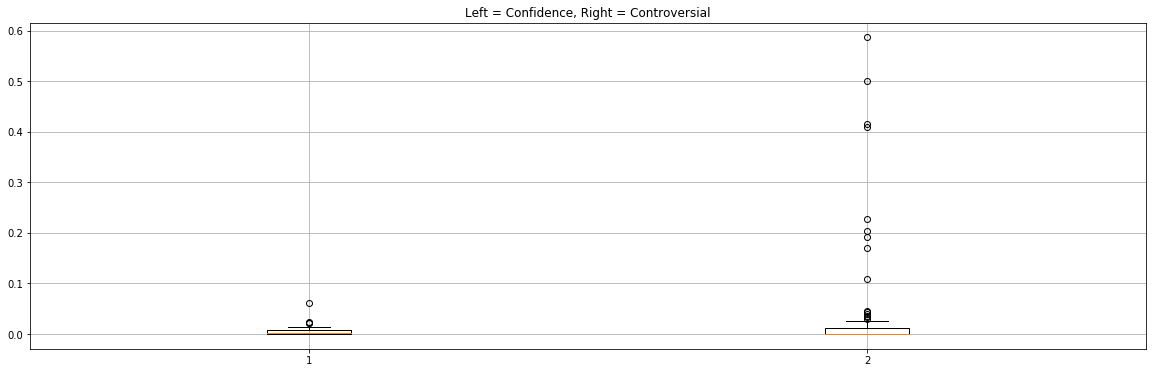

In [49]:
plot_statistics_republication(df_republication2)

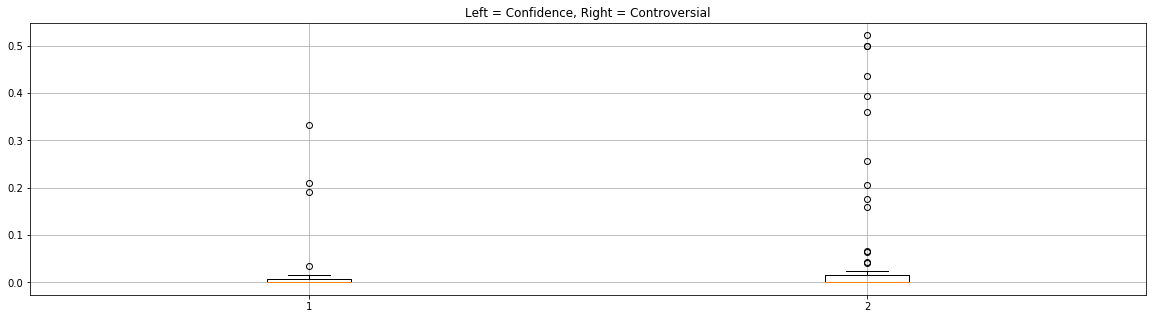

In [236]:
data = [df_republication_confidence['Republication'], df_republication_controversial['Republication']]
fig, ax = plt.subplots()
ax.set_title('Left = Confidence, Right = Controversial')
ax.boxplot(data)

plt.grid()
plt.show()

## Conclusion
- Les sites de controverses ont la même attitude que les sites de confiance : ils cherchent à se "cacher" parmis eux
- Inverse de ce qu'on attendait => Fake republie plus que Confiance

# FOR 1 WEEK

In [16]:
all_data_path='1_week_all_data_from_20180623_to_20180630'
df_all_data=open_data(all_data_path);

################################################################################################
#Computation of republication 
df_republication=pd.DataFrame(columns=['WebsiteURL','Republication'])
pbar = tqdm(total=len(df_all_data.MentionSourceName.unique()))
for counter,websiteURL in enumerate(df_all_data.MentionSourceName.unique()) : #for each website
    list_event=list(df_all_data[df_all_data.MentionSourceName==websiteURL].GlobalEventID)
    republication_criterion=(len(list_event)-len(set(list_event)))/len(list_event) #=% de republication = (nb_total-nb_unique)/nb_total = nb_republication/nb_total
    df_republication = df_republication.append({'WebsiteURL': websiteURL, 'Republication':republication_criterion}, ignore_index=True)
    pbar.update(1)
    
pbar.close()
#tqdm enumerate 

df_republication.set_index('WebsiteURL',inplace=True)

# Add referencies
confidence_type=['political','reliable','confidence']
controversial_type=['bias','fake','conspiracy','unknown','satire','hate','clickBait','clickbait','junksci','rumor',
                    'unreliable','state','controversial']
fake_news_sources_df=pd.read_csv('Classification_Website_False.csv',sep = ';',decimal = '.')
fake_news_sources_df.set_index('url',inplace=True)
fake_news_sources=list(fake_news_sources_df.index.unique())
fake_news_sources_df.index.names = ['WebsiteURL']
reference=fake_news_sources_df.type.to_frame() 
df_republication2=pd.merge(df_republication, reference, how='inner',left_index=True, right_index=True)

C:\Users\maell\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
100%|██████████████████████████████████████████████████████████████████████████| 15705/15705 [1:21:45<00:00,  3.63it/s]


In [33]:
#df_republication2.to_csv('republication_1_week_from_20180623_to_20180630.csv')

In [50]:
df_republication2=pd.read_csv('republication_1_week_from_20180623_to_20180630.csv',sep = ',',decimal = '.',index_col=0)

In [51]:
df_republication2

,Republication,type
WebsiteURL,,
21stcenturywire.com,0.000000,conspiracy
advocate.com,0.007905,political
ahtribune.com,0.000000,unreliable
alternet.org,0.014493,political
americanfreepress.net,0.000000,conspiracy
americanprogress.org,0.000000,political
americanthinker.com,0.025680,bias
antiwar.com,0.000000,bias
awdnews.com,0.000000,conspiracy


,mean,median,max,min,quartiles,% of no republication
type,,,,,,
Controversial,0.034090,0.586585,0.586585,0.0,0.25 0.000000 0.50 0.000000 0.75 0.01...,0.684211
Confidence,0.006632,0.061856,0.061856,0.0,0.25 0.000000 0.50 0.001272 0.75 0.00...,0.500000


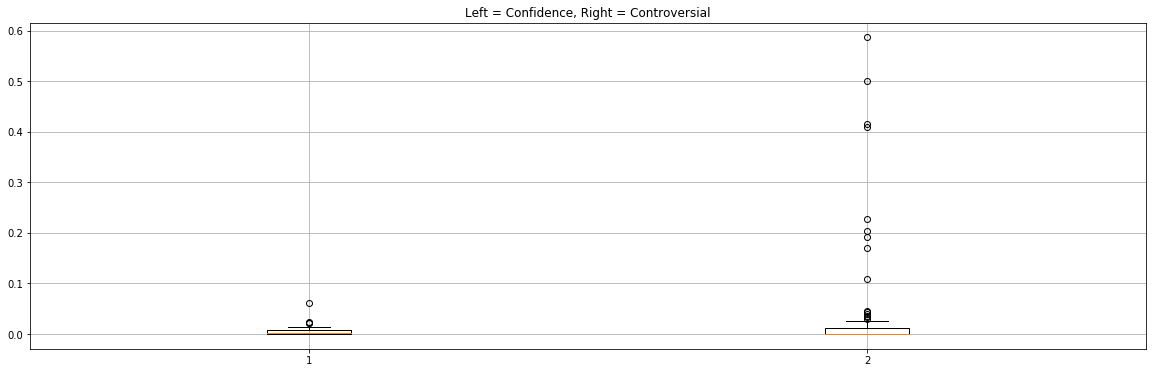

In [54]:
plot_statistics_republication(df_republication2)

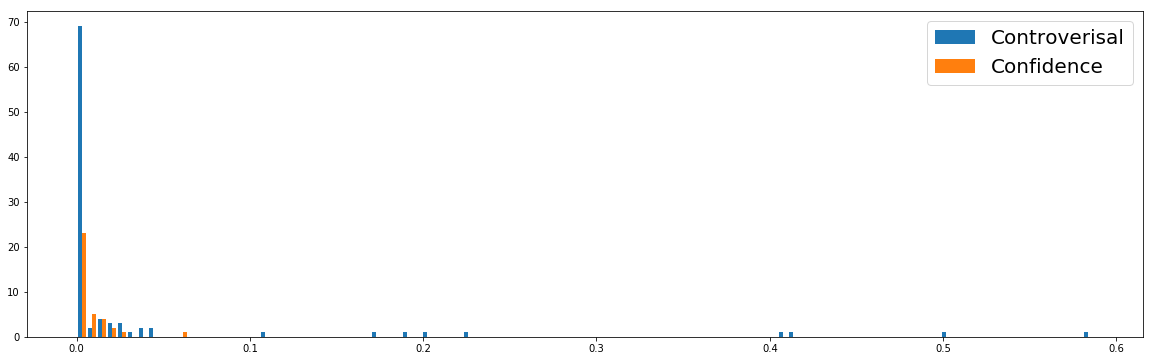

In [29]:
df_republication_controversial=df_republication2[df_republication2['type'].isin(controversial_type)]
df_republication_confidence=df_republication2[df_republication2['type'].isin(confidence_type)]
plt.rcParams['figure.figsize'] = (20, 6)
import seaborn as sns
#sns.distplot(df_republication_controversial['Republication'],label='Controversial',kde=False, norm_hist=True);
#sns.distplot(df_republication_confidence['Republication'],label='Confidence',kde=False, norm_hist =True);
#plt.legend()


plt.hist([df_republication_controversial['Republication'], df_republication_confidence['Republication']], bins=100)
plt.legend(['Controverisal','Confidence'],prop={'size': 20})

In [68]:
df_republication_confidence[df_republication_confidence['Republication']==max(df_republication_confidence['Republication'])]

,Republication,type
WebsiteURL,,
washingtonexaminer.com,0.061856,political


## Conclusion
Certains sites de controverse ont un taux de republication bien plus élevé que les sites de confiance.
Hypothèses :
- Les sites de controverse ont peu de personnel, ils ne peuvent donc écrire qu'un nombre réduit d'articles. Pour augmenter leur audiance, ils republient donc énormément.
- Les sites de confiances republient (?), mais avec leur force journalistique ils publient également de nombreux nouveaux articles en lien avec de nouveau évenement : cela fait baisser leur taux de republication.

**Prochaines interrogations à éclaircir :**
- "Republication" = nouvel article ou bien mise à jour de l'ancien ? Si nouvel article, cela étaille nos hypothèses.

# TYPE OF REPUBLICATION

Le plus grand "republieur" cette semaine là est le 'washingtonexaminer.com'.
Observons quelle est la type de republication.

In [69]:
all_data_path='1_week_all_data_from_20180623_to_20180630'
df_all_data=open_data(all_data_path);

C:\Users\maell\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [72]:
df_all_data.head()

,GlobalEventID,EventTimeDate,MentionTimeDate,MentionType,MentionSourceName,MentionIdentifier,SentenceID,Actor1CharOffset,Actor2CharOffset,ActionCharOffset,InRawText,Confidence,MentionDocLen,MentionDocTone,MentionDocTranslationInfo,Extras
0,667330433.0,2.017062e+13,2.018062e+13,1.0,9news.com.au,https://www.9news.com.au/national/2018/06/22/1...,4.0,-1.0,2220.0,2249.0,1.0,80.0,3233.0,4.063604,NaN,NaN
1,667332152.0,2.017062e+13,2.018062e+13,1.0,lasalle.edu,https://www.lasalle.edu/blog/2018/06/22/la-sal...,5.0,-1.0,462.0,477.0,1.0,100.0,1273.0,5.309735,NaN,NaN
2,766498492.0,2.018062e+13,2.018062e+13,1.0,irishexaminer.com,https://www.irishexaminer.com/breakingnews/vie...,25.0,-1.0,7867.0,7859.0,0.0,20.0,15858.0,-5.619266,NaN,NaN
3,766498493.0,2.018062e+13,2.018062e+13,1.0,centralmaine.com,https://www.centralmaine.com/2018/06/22/usda-t...,5.0,-1.0,2209.0,2193.0,0.0,40.0,4916.0,0.000000,NaN,NaN
4,766498494.0,2.018062e+13,2.018062e+13,1.0,chronicle.co.zw,http://www.chronicle.co.zw/ed-recounts-poisoni...,5.0,1078.0,-1.0,1101.0,0.0,20.0,3716.0,-0.768049,NaN,NaN


In [97]:
df_type_repu=df_all_data[df_all_data['MentionSourceName']=='washingtonexaminer.com'].sort_values(by=['GlobalEventID'])
df_type_repu

,GlobalEventID,EventTimeDate,MentionTimeDate,MentionType,MentionSourceName,MentionIdentifier,SentenceID,Actor1CharOffset,Actor2CharOffset,ActionCharOffset,InRawText,Confidence,MentionDocLen,MentionDocTone,MentionDocTranslationInfo,Extras
179132,668040550.0,2.017063e+13,2.018063e+13,1.0,washingtonexaminer.com,https://www.washingtonexaminer.com/policy/heal...,17.0,3522.0,-1.0,3539.0,1.0,30.0,4166.0,-2.100840,NaN,NaN
160558,668603604.0,2.017063e+13,2.018063e+13,1.0,washingtonexaminer.com,https://www.washingtonexaminer.com/news/white-...,11.0,3268.0,-1.0,3282.0,0.0,30.0,4952.0,3.757576,NaN,NaN
521872,668845103.0,2.017063e+13,2.018063e+13,1.0,washingtonexaminer.com,https://www.washingtonexaminer.com/policy/econ...,9.0,3004.0,3179.0,3164.0,1.0,90.0,5894.0,-1.587302,NaN,NaN
97316,668845103.0,2.017063e+13,2.018063e+13,1.0,washingtonexaminer.com,https://www.washingtonexaminer.com/policy/econ...,9.0,2993.0,3168.0,3153.0,1.0,90.0,5894.0,-1.588983,NaN,NaN
408564,759364890.0,2.018053e+13,2.018063e+13,1.0,washingtonexaminer.com,https://www.washingtonexaminer.com/washington-...,7.0,1404.0,-1.0,1393.0,0.0,20.0,1661.0,-1.052632,NaN,NaN
408533,759366680.0,2.018053e+13,2.018063e+13,1.0,washingtonexaminer.com,https://www.washingtonexaminer.com/washington-...,7.0,-1.0,1404.0,1393.0,0.0,20.0,1661.0,-1.052632,NaN,NaN
408565,759368000.0,2.018053e+13,2.018063e+13,1.0,washingtonexaminer.com,https://www.washingtonexaminer.com/washington-...,7.0,1404.0,-1.0,1393.0,1.0,80.0,1661.0,-1.052632,NaN,NaN
408534,759370617.0,2.018053e+13,2.018063e+13,1.0,washingtonexaminer.com,https://www.washingtonexaminer.com/washington-...,7.0,-1.0,1404.0,1393.0,1.0,80.0,1661.0,-1.052632,NaN,NaN
546096,759371607.0,2.018053e+13,2.018063e+13,1.0,washingtonexaminer.com,https://www.washingtonexaminer.com/news/trump-...,4.0,992.0,-1.0,1120.0,0.0,20.0,1083.0,-1.149425,NaN,NaN
546078,759375826.0,2.018053e+13,2.018063e+13,1.0,washingtonexaminer.com,https://www.washingtonexaminer.com/news/trump-...,4.0,-1.0,992.0,1120.0,0.0,20.0,1083.0,-1.149425,NaN,NaN


In [79]:
df_type_repu[df_type_repu['GlobalEventID']==668845103.0].MentionIdentifier

521872    https://www.washingtonexaminer.com/policy/econ...
97316     https://www.washingtonexaminer.com/policy/econ...
Name: MentionIdentifier, dtype: object

In [99]:
print(df_type_repu.loc[521872].MentionIdentifier)
print(df_type_repu.loc[97316].MentionIdentifier)

https://www.washingtonexaminer.com/policy/economy/union-effort-undermine-supreme-court-janus-ruling
https://www.washingtonexaminer.com/policy/economy/union-effort-well-underway-to-undermine-supreme-courts-ruling-on-fees


In [95]:
print(df_type_repu.loc[546078].MentionIdentifier)
print(df_type_repu.loc[546087].MentionIdentifier)

https://www.washingtonexaminer.com/news/trump-2020-campaign-manager-60-percent-of-minnesota-rally-crowd-was-democratic-independent
https://www.washingtonexaminer.com/policy/defense-national-security/house-senate-spending-plans-aim-to-boost-f-35-purchases


# Conclusion
- Sometimes lead to the same article, even with different links. Keep the first name of article but change url. And the early articles redirect url to latest one
- Sometimes not the same event at all ...  Be carefull of the pied de page qui est le meme ....

=> Really need to be careful !